In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from collections import defaultdict 

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
def parse_accs(fname):
    f_string = ''
    with open(fname, 'r') as f:
        for line in f.readlines():
            f_string += (f' {line}')

    perfs = f_string.split('[random_search]')
    perfs = list(filter(lambda s: 'conf=' in s, perfs))
    perf_dict = defaultdict(list)
    for p in perfs:
        s = p.strip().split(',')
        s = [item.strip() for item in s]
        conf = s[0].replace('conf=', '')
        seed = int(s[1].replace('seed=', ''))
        acc = float(s[2].replace('acc=', ''))
        perf_dict[conf].append(acc)

    means = []
    maxs = []
    mins = []
    stds = []
    points = []
    confs = []
    for k in perf_dict.keys():
        means.append(np.mean(perf_dict[k]))
        maxs.append(np.max(perf_dict[k]))
        mins.append(np.min(perf_dict[k]))
        stds.append(np.std(perf_dict[k]))
        points.append(perf_dict[k])
        confs.append(k)

    return means, maxs, mins, stds, points, confs
    
means, maxs, mins, stds, points, confs = parse_accs('results/random_search.log')

In [4]:
points[np.argmax(means)]

[0.3821, 0.4397, 0.4321]

In [5]:
h = confs[np.argmax(means)]
h

'[5.92212138e-02 1.11815863e-01 1.28464862e-01 8.48805478e-02\n  4.19379279e-04 4.04951095e-02 2.02454160e-02 5.72815361e-02\n  4.97176072e-01]'

In [6]:
np.max(means)

0.41796666666666665

In [7]:
len(means)

253

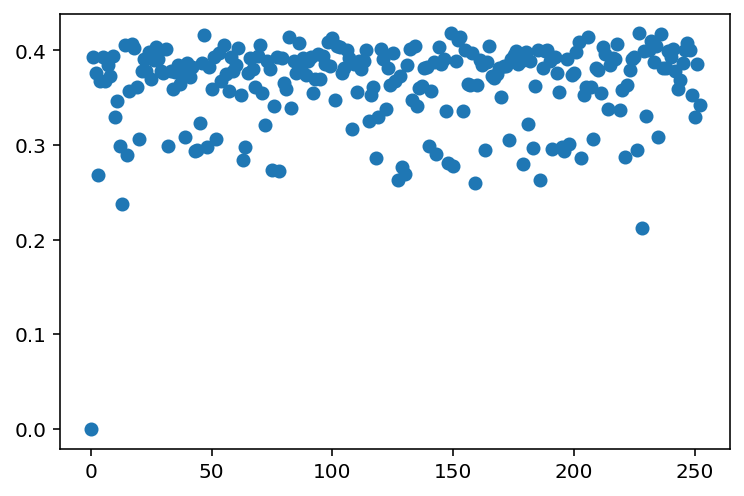

In [8]:
plt.scatter(np.arange(len(means)), means)


In [9]:
rs = []
for i in range(len(means)):
    rs.append(np.max(means[:i+1]))
rs = np.array(rs)

In [10]:
max_stds = []
for i in range(len(means)):
    max_stds.append(maxs[np.argmax(means[:i+1])])
max_stds = np.array(max_stds)

In [11]:
min_stds = []
for i in range(len(means)):
    min_stds.append(mins[np.argmax(means[:i+1])])
min_stds = np.array(min_stds)

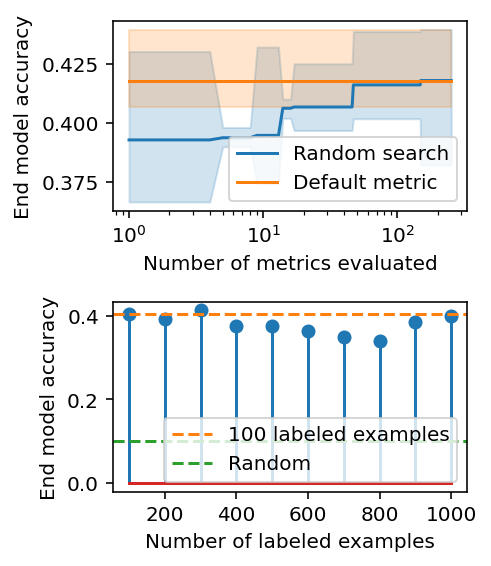

In [12]:

fig, ax = plt.subplots(2, 1, figsize=(3.5, 4))

ax[0].plot(np.arange(1, len(means)), rs[1:], color='C0', label='Random search')
ax[0].fill_between(np.arange(1, len(means)), 
    min_stds[1:], 
    max_stds[1:],
    color='C0', alpha=0.2)

ax[0].set_xlabel('Number of metrics evaluated')
ax[0].set_ylabel('End model accuracy')
#plt.title('Random search for metric combinations')
defaults = [0.4068, 0.4393, 0.4066]
ax[0].plot(np.arange(1, len(means)), np.ones_like(means[1:]) * np.mean(defaults), 
    color='C1', label='Default metric')
ax[0].fill_between(np.arange(1, len(means)), 
    np.min(defaults), 
    np.max(defaults),
    color='C1', alpha=0.2)

ax[0].set_xscale('log')
ax[0].legend(frameon=True, loc='lower right')
#plt.savefig('random_search.pdf', bbox_inches='tight')
#plt.show()



def parse_accs(fname):
    fin_acc = 0
    with open(fname, 'r') as f:
        for line in f.readlines():
            if 'end model (LeNet) test acc: ' in line:
                fin_acc = float(line.split()[-1])
    return fin_acc


seed = 0

get_acc_npoints = lambda n: parse_accs(
    f'results/mnist/snuba_nlabels/n_labeled_points_{n}/res_seed{seed}.log')

nlabels = np.arange(100, 1100, 100)
npoints = [get_acc_npoints(n) for n in nlabels]

npoints[0] = 0.4037


(markerline, stemlines, baseline) = plt.stem(nlabels, npoints)
#plt.setp(baseline, visible=False)
ax[1].axhline(
    npoints[0], 
    linestyle='--', color='C1', label=f'100 labeled examples')
ax[1].axhline(
    0.1, 
    linestyle='--', color='C2', label=f'Random')

ax[1].set_xticks(nlabels[1::2])
ax[1].set_ylabel('End model accuracy')
ax[1].set_xlabel('Number of labeled examples')

ax[1].legend(frameon=True, loc='lower right')

plt.tight_layout()
plt.savefig('neurips/snuba_ablation_1.pdf', bbox_inches='tight')
plt.show()

In [30]:
import optperfprofpy

def my_draw_simple_pp(taus, solver_vals, solvers, ax,
        fname="performance_profiles.pdf", xlim=None, log=False, frameon=False, 
        colors=None, legend=True):
    """Simple step plotter for performance profiles.
    Parameters
    ----------
    taus : numpy.ndarray
        x values of plot.
    solver_vals : numpy.ndarray
        y values of plot.
    solvers : list
        Labels of curves.
    """

    if colors is None:
        colors = [f"C{i}" for i in range(10)]

    # Add lines individually to support labels
    for n, solver in enumerate(solvers):
        ax.step(taus, 
            solver_vals[n, :], alpha=0.5, linewidth=3, 
            label=solver, color=colors[n], where='post')

    if legend:
        ax.legend(frameon=frameon,)
    if xlim == None:
        ax.set_xlim(1, taus.max())
    else:
        ax.set_xlim(1, xlim)
    if log:
        ax.set_xscale("log")
    ax.set_xlabel(r"$\tau$")
    ax.set_ylabel(r"$\rho_{s}(\tau)$")


Number of problems per solver:  5


/hdd2/nick/anaconda3/envs/FWRENCH/lib/python3.7/site-packages/ipykernel_launcher.py:162: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


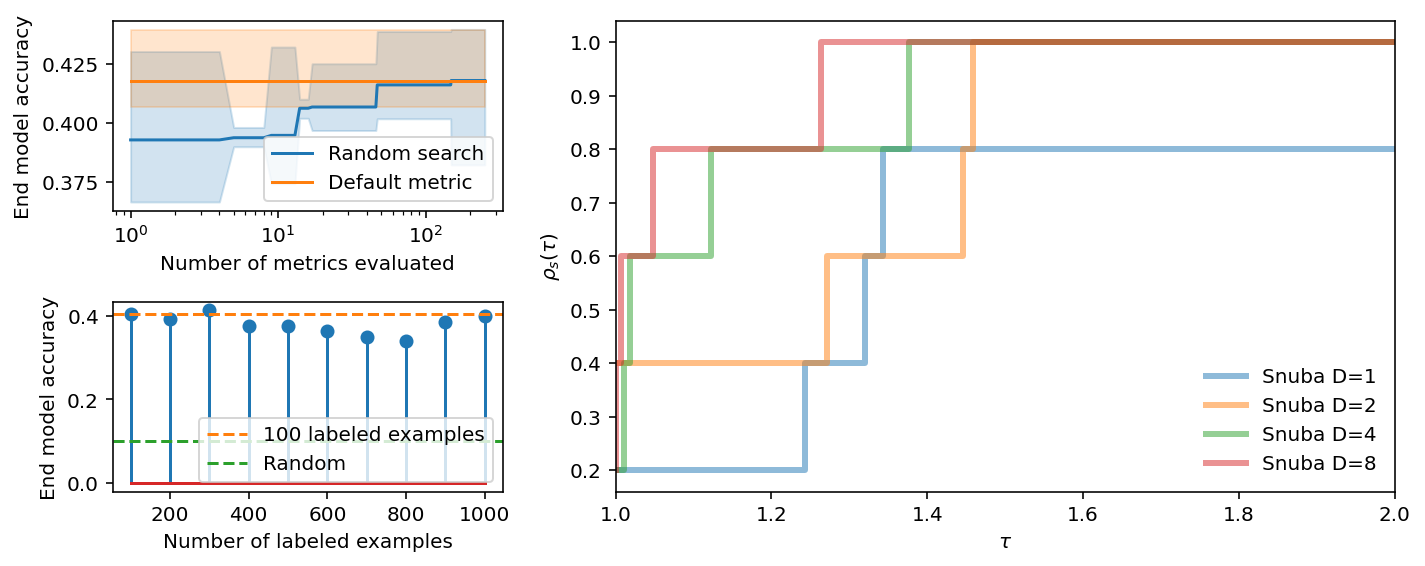

In [31]:
gs_kw = dict(width_ratios=[1, 2], height_ratios=[1, 1])
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               gridspec_kw=gs_kw, 
                              figsize=(10, 4), constrained_layout=True)

axd['upper left'].plot(np.arange(1, len(means)), rs[1:], color='C0', label='Random search')
axd['upper left'].fill_between(np.arange(1, len(means)), 
    min_stds[1:], 
    max_stds[1:],
    color='C0', alpha=0.2)

axd['upper left'].set_xlabel('Number of metrics evaluated')
axd['upper left'].set_ylabel('End model accuracy')
#plt.title('Random search for metric combinations')
defaults = [0.4068, 0.4393, 0.4066]
axd['upper left'].plot(np.arange(1, len(means)), np.ones_like(means[1:]) * np.mean(defaults), 
    color='C1', label='Default metric')
axd['upper left'].fill_between(np.arange(1, len(means)), 
    np.min(defaults), 
    np.max(defaults),
    color='C1', alpha=0.2)

axd['upper left'].set_xscale('log')
axd['upper left'].legend(frameon=True, loc='lower right')
#plt.savefig('random_search.pdf', bbox_inches='tight')
#plt.show()



def parse_accs(fname):
    fin_acc = 0
    with open(fname, 'r') as f:
        for line in f.readlines():
            if 'end model (LeNet) test acc: ' in line:
                fin_acc = float(line.split()[-1])
    return fin_acc


seed = 0

get_acc_npoints = lambda n: parse_accs(
    f'results/mnist/snuba_nlabels/n_labeled_points_{n}/res_seed{seed}.log')

nlabels = np.arange(100, 1100, 100)
npoints = [get_acc_npoints(n) for n in nlabels]

npoints[0] = 0.4037


(markerline, stemlines, baseline) = plt.stem(nlabels, npoints)
#plt.setp(baseline, visible=False)
axd['lower left'].axhline(
    npoints[0], 
    linestyle='--', color='C1', label=f'100 labeled examples')
axd['lower left'].axhline(
    0.1, 
    linestyle='--', color='C2', label=f'Random')

axd['lower left'].set_xticks(nlabels[1::2])
axd['lower left'].set_ylabel('End model accuracy')
axd['lower left'].set_xlabel('Number of labeled examples')

axd['lower left'].legend(frameon=True, loc='lower right')













ntotal_task = 5
nrows = 4
rowlist = [0]
tasklist = [0, 1, 2, 3, 4]
assert len(tasklist) <= 5
ntask = len(tasklist)
inds = np.array([[t + (ntotal_task * row) for t in tasklist] for row in rowlist]).reshape(-1).tolist()





snuba1_perfs = [
        0.7667, 0.7262, 0.1521, 0.1323, 0.4116,
        ]

snuba2_perfs = [
        0.7033, 0.7025, 0.0714, 0.3016, 0.79157
        ]

snuba4_perfs = [
        0.6788, 0.79610, 0.3506, 0.2164, 0.7878
        ]

snuba8_perfs = [
        0.7051, 0.79479, 0.3577, 0.2678, 0.7915
        ]

snuba10_perfs = [
        0.68718, 0.79479, 0.3605, 0.2321, 0.79157
        ]



snuba1_perfs = np.array(snuba1_perfs)[inds].tolist()
snuba2_perfs = np.array(snuba2_perfs)[inds].tolist()
snuba4_perfs = np.array(snuba4_perfs)[inds].tolist()
snuba8_perfs = np.array(snuba8_perfs)[inds].tolist()
#snuba10_perfs = np.array(snuba10_perfs)[inds].tolist()

problems = pd.Series(
        np.arange(len(snuba1_perfs)).tolist() + \
        np.arange(len(snuba2_perfs)).tolist() + \
        np.arange(len(snuba4_perfs)).tolist() + \
        np.arange(len(snuba8_perfs)).tolist(),
        dtype=int, name='problem')
methods = pd.Series(
        [r'Snuba D=1'] * len(snuba1_perfs) + \
        [r'Snuba D=2'] * len(snuba2_perfs) + \
        [r'Snuba D=4'] * len(snuba4_perfs) + \
        [r'Snuba D=8'] * len(snuba8_perfs),
        dtype=str, name='method')


objective_vals = pd.Series(
        1.0 - np.array(
                snuba1_perfs + \
                snuba2_perfs + \
                snuba4_perfs + \
                snuba8_perfs,
                ), 
        dtype=float, name='obj')

df = pd.DataFrame([problems, methods, objective_vals]).T

taus, solver_vals, solvers, transformed_data = optperfprofpy.calc_perprof(
    df, ['problem'], ['obj'], ['method'])


my_draw_simple_pp(
        taus, solver_vals, solvers, axd['right'], 
        xlim=2, log=False, frameon=False)












plt.tight_layout()
plt.savefig('neurips/snuba_ablation.pdf', bbox_inches='tight')
plt.show()